In [1]:
import pytorch_lightning as pl
from matplotlib import pyplot as plt
import seaborn as sns
from cca_zoo.deepmodels import (
    DCCA,
    DCCA_NOI,
    DCCA_SDL,
    BarlowTwins,
    get_dataloaders,
    
)
from cca_zoo.deepmodels.utils import architectures, objectives
from cca_zoo.plotting import pairplot_label
from cca_zoo.data import CCA_Dataset
from cca_zoo.models import CCA

from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np


os.chdir('../raw_data')


In [3]:
os.listdir()

['ALL_GNPS.json',
 'ALL_GNPS_15_12_2021_positive_annotated.pickle',
 'ALL_GNPS_15_12_2021_positive_annotated_classifications.txt',
 'all_ms2ds_embedding.pickle',
 'all_spec_embedding.pickle',
 'df_ALL_GNPS_15_12_2021_positive_annotated_embeddings_class.pickle',
 'df_classes_all_embeddings.pickle',
 'df_classes_max3_embeddings.pickle',
 'df_classes_max5_embeddings.pickle',
 'df_classes_unique_embeddings.pickle',
 'GNPS_15_12_2021_ms2ds_embeddings.pickle',
 'lightning_logs',
 'max3_mol2vec_embedding.pickle',
 'max3_ms2ds_embedding.pickle',
 'max3_spec_embedding.pickle',
 'max5_mol2vec_embedding.pickle',
 'max5_ms2ds_embedding.pickle',
 'max5_spec_embedding.pickle',
 'model_300dim.pkl',
 'mol2vec_embedding.pickle',
 'ms2ds_embeddings_unique_GNPS_15_12_2021.pickle',
 'ms2ds_model_GNPS_15_12_2021.hdf5',
 'ms2ds_pred_euc',
 'plot_validation.py',
 'spec2vec_embeddings_unique_GNPS_15_12_2021.pickle',
 'spec2vec_model_GNPS_15_12_2021.model',
 'spec2vec_model_GNPS_15_12_2021.model.syn1neg.npy',


#### Functions to load and or write to pickle files

In [2]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

In [87]:
# load df with all info
path = './df_classes_unique_embeddings.pickle'
df_all = Files(path).load_pickle()#[:2000] #just a subset for scripting
df_all.shape

(20889, 8)

In [88]:
#split into train and test dataset
train_df, test_df = \
train_test_split(df_all, test_size=0.3, random_state=42)#, stratify=df_all['cf_class'])

#Split train dataset into train and validation set
test_df, val_df = train_test_split(test_df, test_size=0.1, random_state=42)


#extract the 2 view, v1 == spectra embeddings, v2==structure embeddings
v1_train, v1_test = np.array([x for x in train_df['ms2ds']]), np.array([x for x in test_df['ms2ds']])
v2_train, v2_test = np.array([x for x in train_df['mol2vec']]), np.array([x for x in test_df['mol2vec']])

# validation
v1_val, v2_val = np.array([x for x in val_df['ms2ds']]), np.array([x for x in val_df['mol2vec']])

In [89]:
# What does CCA dataset do????
train_dataset = CCA_Dataset([v1_train, v2_train])
test_dataset = CCA_Dataset([v1_test, v2_test])
val_dataset = CCA_Dataset([v1_val, v2_val])

train_loader , val_loader = get_dataloaders(train_dataset, val_dataset, batch_size=128, num_workers=6,
                                              drop_last=False)
test_loader = get_dataloaders(test_dataset,batch_size=128, num_workers=6,
                                              drop_last=False)

In [94]:
#params
N = len(train_dataset)
latent_dims = 100
epochs = 100
#cca = CCA(latent_dims=latent_dims).fit((X, Y))

# define encoders
encoder_1 = architectures.Encoder(latent_dims=100, feature_size=v1_train.shape[1], layer_sizes=(200,))
                                     
encoder_2 = architectures.Encoder(latent_dims=100, feature_size=v2_train.shape[1], layer_sizes=(200,))

# define variant algorithmns
# 1. DCCA
dcca = DCCA(
        latent_dims=latent_dims,
        encoders=[encoder_1, encoder_2],
        objective=objectives.CCA,
        )

# 2. SDL
sdl = DCCA_SDL(latent_dims,
                N=N, encoders=[encoder_1, encoder_2],
                lam=1e-2, lr=1e-3)

# Define the trainer
trainer = pl.Trainer(
        max_epochs=epochs, log_every_n_steps=1,
        callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="train/objective")])# early stopage to reduce overfitting

# train
trainer.fit(sdl, train_loader,val_loader)

#transform the views to get z projections


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | encoders | ModuleList | 140 K 
1 | mse      | MSELoss    | 0     
2 | bns      | ModuleList | 0     
----------------------------------------
140 K     Trainable params
0         Non-trainable params
140 K     Total params
0.562     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [81]:
dcca_corr = dcca.score(train_loader)
dcca_corr

array([0.87858718, 0.86496665, 0.84730405, 0.83808206, 0.83106527,
       0.80043461, 0.77821529, 0.75343301, 0.71894609, 0.70651211,
       0.69521138, 0.6930434 , 0.68272434, 0.67203175, 0.66121396,
       0.64593414, 0.63517189, 0.62323784, 0.60901107, 0.59603238,
       0.58949415, 0.57447204, 0.57238723, 0.55790291, 0.55055037,
       0.54135297, 0.53284899, 0.52428912, 0.52055145, 0.50207373,
       0.49163577, 0.48821106, 0.48363428, 0.47901978, 0.46729663,
       0.46376409, 0.4588725 , 0.43307625, 0.43034021, 0.42384107,
       0.41952706, 0.41587309, 0.40651779, 0.40169271, 0.39304899,
       0.37728256, 0.36720237, 0.35898486, 0.35547697, 0.35061316,
       0.33560172, 0.33270352, 0.32795068, 0.32076527, 0.30934248,
       0.30730683, 0.30423667, 0.30097193, 0.29128099, 0.28647251,
       0.26932788, 0.26286434, 0.25903427, 0.25362207, 0.24439565,
       0.23907516, 0.23024718, 0.21997008, 0.21599459, 0.21072784,
       0.19988308, 0.19865032, 0.1910241 , 0.18621353, 0.17996

In [82]:
dcca_test_corr = dcca.score(test_loader)
dcca_test_corr

array([0.93012168, 0.92156788, 0.90898547, 0.88830893, 0.88134465,
       0.86949579, 0.86404163, 0.84997756, 0.84035269, 0.83250734,
       0.81924022, 0.81167813, 0.80732471, 0.80010409, 0.78855749,
       0.77307859, 0.76991841, 0.76251831, 0.74565387, 0.74208061,
       0.73016111, 0.71788071, 0.71412847, 0.70277473, 0.69481833,
       0.68739003, 0.68228213, 0.67157232, 0.66251033, 0.65578481,
       0.64166338, 0.63746385, 0.63572013, 0.62018213, 0.61343173,
       0.60235973, 0.59971207, 0.58349718, 0.57314809, 0.56664073,
       0.56057306, 0.5507338 , 0.54662204, 0.53329003, 0.52845268,
       0.5185946 , 0.50599405, 0.5035397 , 0.48499264, 0.47385346,
       0.47082439, 0.45368313, 0.44228408, 0.43681989, 0.42894533,
       0.4207439 , 0.4169637 , 0.41094733, 0.39291887, 0.38963347,
       0.38141386, 0.37719001, 0.37583194, 0.35952572, 0.34033982,
       0.33565479, 0.32071008, 0.31267616, 0.30492741, 0.29643611,
       0.2823989 , 0.27156397, 0.25260984, 0.24620004, 0.23971

In [ ]:
sdl_train_corr = sdl.score(train_loader)
sdl_train_corr[0:5]

In [92]:
sdl_test_corr = sdl.score(test_loader)
sdl_test_corr[0:5]

array([0.81779107, 0.63632225, 0.62819343, 0.62441051, 0.60417946])

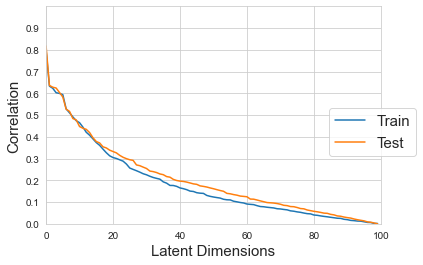

In [93]:
# plot train correlation vs test correlation
x=[x for x in range(latent_dims)]
fig, ax = plt.subplots()
sns.set_style('whitegrid')
dfs = [sdl_train_corr,sdl_test_corr]
for df in dfs:
    sns.lineplot(x=x,y=df,ax=ax)
fig.legend(labels=['Train', 'Test'], loc='center right', fontsize=15)
plt.xlabel('Latent Dimensions', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.ylim(0, 1)
plt.xlim(0, latent_dims)
plt.yticks(np.arange(0, 1, step=0.1))
plt.show()

In [175]:
#score test dataset
# check the validation loop warning

In [78]:
v1_train.shape

(11200, 200)